# Towards engineering of reciprocal systems 

In this notebook we introduce the accounting mechanism and its use in reputation and trust systems.

The reptuation algorithm is used here in a specific context: 
 - We assume an *accounting mechansim*: it guarantees discovery, convergence of information, and protects from peer slandering: misinformation on the data accounted about one node. The event is correctly recorded in the ledger, with help of two signatures from the peers.       
 - Reputation is build on a work graph: a directed weighted graph of agents interactions. An edge in a graph is a instance of interaction. The authecthicity of interation can be verified via cryptographic signatures. 
 - The work graph is kept updated with every new iteration. Each new iteration updates the value of the interaction. 


### Test workload: model of the work graph

The interaction between the agents is modeled as a directed weighted graph. We assume an arbitary model of interaction (random graph model). We test againts the following models:
1. Power law distribution: Bittorent data distriubtion, Bitcoin transaction graph
2. Random, uniform: relay nodes 

 
## 1. Trust Functions comparison

Each trust algorithm will be analyzed by these two parameters: 

1. *Informativeness* - how good can the algorithms do 2 tasks: **filtering** (identifing cheaters/freeriders etc.) and **ranking** (choosing top K).
2. *Robustness* - how can trust algorithm resists attacks and manipulation of the algorithms. Specifically, the attacks that manipulate the scores by creating fake connections and nodes. 

## 2. Information exchange and Incomplete knowledge

Each agent acts only according to known information. The information is not guaranteed to be complete. Agents periodcially exchange information with each other.

We show how partial knowledge affects the informativeness and robustness of the reputation and trust algorithms.
1. How the reputation algorithms properties change with partial knowledge? 
2. What is the minimal required information to have a useful reputation algorithm.

### Information distribution 

The information exchange is modeled as a random process. With respect to the information exchange we propose three schemes: 
1. Structured overlay: DHT-like distribution of data.
2. Unstructured overlay: gossip-like distribution of data.
3. Full broadcast with periodical partitioning. 



## Input: Generate work graph


Work graph (aka contribution graph) is a network of contribution (who to who, peer-to-peer).
We consider two work graph generators: 
 - ``wg_pl``:  Power-Law, for example bittorrent content, wikipedia pages, etc. 
 - ``wg_wf``: Uniform, random - relaying information


In [47]:
from common import draw_distribution, generate_work_graph_power_law, generate_work_graph_uniform

In [48]:
N = 100 # number of peers 

wg_pl = generate_work_graph_power_law(N)
wg_uf = generate_work_graph_uniform(N)

394.82110000000006 1.0


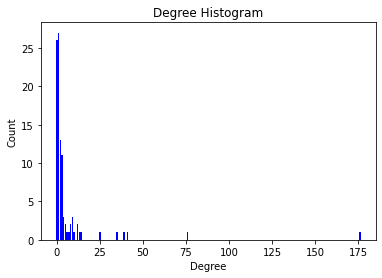

In [49]:
draw_distribution(list(dict(wg_pl.in_degree(weight='weight')).values()))

45.70109999999997 4.0


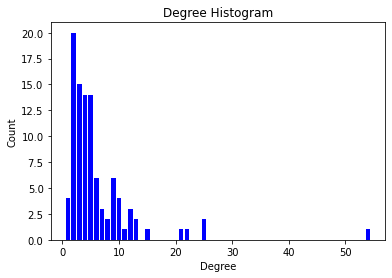

In [50]:
draw_distribution(list(dict(wg_pl.out_degree(weight='weight')).values()))

# Reputation function families 

We consider a specific subset of reputation algorithms that have the following properties: 
- Can work on a work graph.
- 


All reputation algorithms are personalized and oriented to estimate the contribution of the peer in the network, where there is mix of direct and indirect experience. 


We consider following for the following trust accounting algorithms: 
1. PageRank: 
 - Personalized 
 - Modified 
2. Hitting Time
 - Personalized 
 - Modified 
3. BarterCast
 - Original 
 - Modified
 - Netflow


In [7]:
from trust import *

In [8]:
def rank_vals(x_val):
    return dict(zip(x_val.keys(), rankdata([-i for i in x_val.values()], method='min')))  

# Absolute values
def abs_rep(G: nx.Graph, val: int, alpha: float = 4):
    return alpha*G.in_degree(val, 'weight') - G.out_degree(val, 'weight')


def rel_rep(G: nx.Graph, val: int, alpha: float = 1):
    return (G.in_degree(val, 'weight') / (1+G.out_degree(val, 'weight'))) ** alpha
    

def draw_rank_vals(x, r, title, log_val = 'symlog', ylim = (None, None), xlim=(None, None)) -> None:
    g = sns.lineplot(list(r.values()), list(x.values()))
    g.axhline(0, ls='--')

    g.set_xscale('log')
    g.set_yscale(log_val)
    g.set(ylim=ylim, xlim=xlim)
    g.set(ylabel='Contribution value', xlabel='Peer ranking', title=title);
    
    return g

### Ranking with Absolute contribution

Alpha x Total_Up - Total_Down


<AxesSubplot:title={'center':'Net Contribution'}, xlabel='Peer ranking', ylabel='Contribution value'>

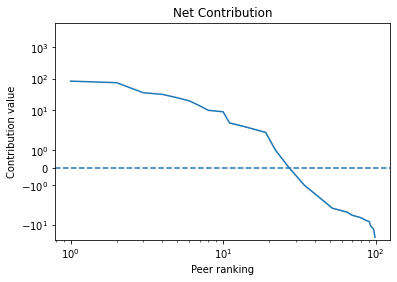

In [9]:
alpha = 1.0

G = wg_pl

gt_x = {k: abs_rep(G, k, alpha=alpha) for k in range(N)}
gt_r = rank_vals(gt_x)

draw_rank_vals(gt_x, gt_r, 'Net Contribution', ylim=(None, 6000))

### Ranking with Relative contribution

In [10]:
source_nodes = list(range(10))

#num_added_sources = 5
#source_nodes = source_nodes | {k for k in random.sample(G.nodes(), num_added_sources)}

def test_informativess(ranking_alg, gt_r, trust_rank_name = '', filter_out: bool = False, **kwargs):
    vals = []
    g = None
    for source_node in source_nodes:
        fil_func =  0 if filter_out else float('-inf')
        x = {k: max(ranking_alg.compute(source_node, k), fil_func) for k in range(N)}
        r = rank_vals(x)
        vals.append(ss.spearmanr(list(gt_r.values()), list(r.values())))

        g= draw_rank_vals(x, r, 'Contribution distribution with {}'.format(trust_rank_name), **kwargs)
        
    fig = g.get_figure()
    fig.savefig(title+".pdf") 
    

    l = [v.correlation for v in vals]
    print(np.min(l), np.mean(l), np.max(l))


### Ranking with the Trust graph

<AxesSubplot:title={'center':'Contribution distribution'}, xlabel='Peer ranking', ylabel='Contribution value'>

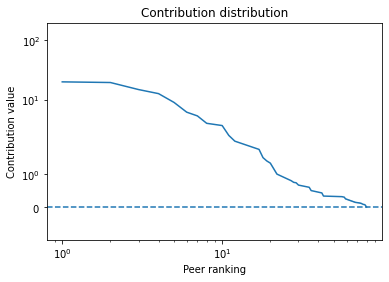

In [11]:
alpha = 1.0

gt_x = {k: rel_rep(G, k, alpha=alpha) for k in range(N)}
gt_r = rank_vals(gt_x)

draw_rank_vals(gt_x, gt_r, 'Contribution distribution', ylim=(None, max(gt_x.values()) * 10))

### Picking the source node for the experiment

In [12]:
from random import sample, seed
from typing import List

# We pick 10 at random:

def random_source_nodes(G: nx.DiGraph, n: int, seed_value: int = None) -> List[int]:
    seed(seed_value)
    return sample(G.nodes, n)


def top_donating_nodes(G: nx.DiGraph, n: int, seed_value: int = None) -> List[int]:
    top_in = sorted(((G.in_degree(i, 'weight'), i) for i in range(N)), reverse=True)[:n]
    return [k[1] for k in top_in]


def top_taking_nodes(G: nx.DiGraph, n: int, seed_value: int = None) -> List[int]:
    top_out = sorted(((G.out_degree(i, 'weight'), i) for i in range(N)), reverse=True)[:n]
    return [k[1] for k in top_out]




### Ranking with the Trust graph

In [13]:
N_range = (100, 500, 1000)

seed_node_choices = ('random', 'top_givers', 'top_takers')
rep_algos = ('pht', 'ppr', 'bc', 'rsbht', 'rspr', 'rsbhtpen')

In [14]:
results = {}

for rep in rep_algos:
    results[rep] = {}
    for s in seed_node_choices:
        results[rep][s] = {}
        for i in N_range:
            results[rep][s][i] = {}


In [15]:
results

{'pht': {'random': {100: {}, 500: {}, 1000: {}},
  'top_givers': {100: {}, 500: {}, 1000: {}},
  'top_takers': {100: {}, 500: {}, 1000: {}}},
 'ppr': {'random': {100: {}, 500: {}, 1000: {}},
  'top_givers': {100: {}, 500: {}, 1000: {}},
  'top_takers': {100: {}, 500: {}, 1000: {}}},
 'bc': {'random': {100: {}, 500: {}, 1000: {}},
  'top_givers': {100: {}, 500: {}, 1000: {}},
  'top_takers': {100: {}, 500: {}, 1000: {}}},
 'rsbht': {'random': {100: {}, 500: {}, 1000: {}},
  'top_givers': {100: {}, 500: {}, 1000: {}},
  'top_takers': {100: {}, 500: {}, 1000: {}}},
 'rspr': {'random': {100: {}, 500: {}, 1000: {}},
  'top_givers': {100: {}, 500: {}, 1000: {}},
  'top_takers': {100: {}, 500: {}, 1000: {}}},
 'rsbhtpen': {'random': {100: {}, 500: {}, 1000: {}},
  'top_givers': {100: {}, 500: {}, 1000: {}},
  'top_takers': {100: {}, 500: {}, 1000: {}}}}

## All experiments run

In [202]:
df

,Unnamed: 0,pht,ppr,bc,rsbht,rspr,rsbhtpen
0,random,"{100: [0.5878578393114711, 0.5410064751834723,...","{100: [0.5839991816597627, 0.5909847042506609,...","{100: [0.6891154479269523, 0.68511546374972, 0...","{100: [0.5173325077479654, 0.6043446539421758,...","{100: [0.5932336578396376, 0.6805248784149217,...","{100: [-0.1589882071444902, 0.4367676503611862..."
1,top_givers,"{100: [0.6259198475539121, 0.6319298291547024,...","{100: [0.6141243798746008, 0.6091184004959278,...","{100: [0.8845258533508902, 0.9377382265694498,...","{100: [0.6786302497515891, 0.6976311091200749,...","{100: [0.7142420996233849, 0.8490554379364225,...","{100: [-0.16594460875779027, -0.16943817946848..."
2,top_takers,"{100: [0.6440932763897119, 0.6178272815047784,...","{100: [0.5975472905541094, 0.5580552929196236,...","{100: [0.8640637586507732, 0.6855166020807882,...","{100: [0.5667370545622518, 0.5949601243872373,...","{100: [0.851050971799948, 0.5817377952206368, ...","{100: [-0.15893874400678323, 0.357458826975897..."


## Filtering 

Simple binary classification: 
- `< 0` balance - freerider - Get 0 
- `> 0` balance - leave as it is 



-----
## Robustness of the algorithms

We analyze the robusteness of these algorithms against sybil attacks with fake data. 



In [246]:
df_f

,pht,ppr,bc,rsbht,rspr,rsbhtpen
random,"{100: [(0.5194805194805194, 0.975609756097561,...","{100: [(0.5946666666666667, 1.0, 0.74581939799...","{100: [(0.8467532467532467, 0.9235127478753541...","{100: [(0.6271604938271605, 0.9694656488549618...","{100: [(0.8805555555555555, 0.9057142857142857...","{100: [(0.8971428571428571, 0.814526588845655,..."
top_givers,"{100: [(0.5063291139240507, 1.0, 0.67226890756...","{100: [(0.5945945945945946, 0.9777777777777777...","{100: [(0.9987012987012988, 0.853496115427303,...","{100: [(0.7794871794871795, 0.9514866979655712...","{100: [(0.970886075949367, 0.8437843784378438,...","{100: [(0.9947368421052631, 0.7605633802816901..."
top_takers,"{100: [(0.7692307692307693, 0.9966777408637874...","{100: [(0.4797297297297297, 1.0, 0.64840182648...","{100: [(0.78125, 0.9384384384384384, 0.8526603...","{100: [(0.7680555555555556, 0.9388794567062818...","{100: [(0.7577464788732394, 0.8663446054750402...","{100: [(0.9056338028169014, 0.7564705882352941..."


## Visualizing results 

In [ ]:
### We visualize 

In [251]:
df_f['pht']['random']

[(0.5194805194805194, 0.975609756097561, 0.6779661016949152),
 (0.6093333333333333, 1.0, 0.7572493786246892),
 (0.6092105263157894, 0.9605809128630706, 0.7455716586151369),
 (0.551948051948052, 1.0, 0.7112970711297071),
 (0.396, 1.0, 0.5673352435530087)]

In [372]:
m_df[m_df['source'] == 'random']

,source,alg,g_n,precision,recall,f1
0,random,pht,100,0.537194,0.987238,0.691884
1,random,pht,500,0.674737,0.963045,0.792483
2,random,pht,1000,0.718318,0.950568,0.818018
3,random,ppr,100,0.601295,0.983462,0.736123
4,random,ppr,500,0.603716,0.983250,0.746154
5,random,ppr,1000,0.572223,0.982441,0.722611
6,random,bc,100,0.831093,0.904981,0.864739
7,random,bc,500,0.752627,0.918076,0.825838
8,random,bc,1000,0.738564,0.922337,0.818842
9,random,rsbht,100,0.717865,0.922818,0.805439


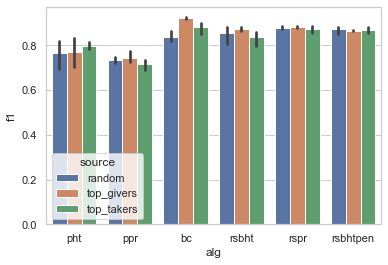

In [382]:
tips = m_df
ax = sns.barplot(x="alg", y="f1", data=tips, hue='source')

# Next notebooks 

**Informativeness**:
- Testing reputation algorithms as a *Ranking algorithms*  
- Testing reputation algorithms as a *Filtering algorithms*

**Robustness**:
- Testing reputation algorithms for Robustness: One attacker with a Sybil

**Imperfect Knowledge**:
- Info


